In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, colors, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [3]:
# Array functions

def array_info(array):
    """Print shape, data type and size in GiB of an array."""
    print(array.shape, array.dtype, '| total size:', array.nbytes/2**30, 'GiB')

def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice centered at zero with given pitch."""
    indices = np.arange(res, dtype=np.float32)
    return (indices - res/2 + 0.5) * pitch

def compute_indices(x, res, pitch):
    """Return indices for given coordinates with respect to given resolution and pitch."""
    return np.floor(x / pitch + res/2).astype(np.int32)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))



# Circle functions

def semicircle(x):
    """Return the positive y coordinate associated to an x coordinate in a unit circle."""
    return cp.sqrt(1.0 - cp.square(x))

def semicircle_integral(x):
    """Return the indefinite integral at x of the semicircle function."""
    return (cp.sqrt(1.0 - cp.square(x)) * x + cp.arcsin(x))/2

def circle_box_area(x_interval, y_interval):
    """Return the area of the intersection of a box against the unit circle."""
    # Positive semicircle medial
    y_clipped = cp.clip(y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area = x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Positive semicircle lateral
    y_clipped = cp.clip(y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle medial
    y_clipped = cp.clip(-y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle lateral
    y_clipped = cp.clip(-y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    return area



# Light field functions

def spatial_display_to_eye(x_a, x_b, z_r, z_a, z_b, z_f):
    x_r = (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b
    x_p = z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b
    return x_r, x_p

def spatial_eye_to_display(x_r, x_p, z_r, z_a, z_b, z_f):
    x_a = (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p
    x_b = (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p
    return x_a, x_b

def frequency_display_to_eye(xi_a, xi_b, z_r, z_a, z_b, z_f):
    xi_r = (z_a/z_r) * xi_a + (z_b/z_r) * xi_b
    xi_p = (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b
    return xi_r, xi_p

def frequency_eye_to_display(xi_r, xi_p, z_r, z_a, z_b, z_f):
    xi_a = (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p
    xi_b = (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p
    return xi_a, xi_b

def take_2d(values, idx_x, idx_y):
    """Return values at given indices. Out of bounds are filled with 0."""
    clipped_idx_x = np.clip(idx_x, -1, values.shape[0]) + 1
    clipped_idx_y = np.clip(idx_y, -1, values.shape[1]) + 1
    return np.pad(values, 1, mode='constant')[clipped_idx_x, clipped_idx_y]

def sample_2d_scene(scene_image, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f, idx_x0=0, idx_y0=0):
    # Compute coordinates
    x_a = compute_coordinates(res_a, size_a / res_a)[:, np.newaxis]
    x_b = compute_coordinates(res_b, size_b / res_b)[np.newaxis, :]
    # Project display samples to the retina plane
    x_r_over_ab = spatial_display_to_eye(x_a, x_b, z_r, z_a, z_b, z_f)[0]
    # Compute corresponding indices on the retina
    idx_r_over_ab = compute_indices(x_r_over_ab, res_r, size_r / res_r)
    # Sample scene
    signal_ab = take_2d(scene_image, idx_r_over_ab[:, np.newaxis, :, np.newaxis] - idx_x0, idx_r_over_ab[np.newaxis, :, np.newaxis, :] - idx_y0)
    return signal_ab

def square_aperture(x_interval, y_interval, pupil_diameter):
    x_interval = cp.clip(x_interval * 2 / pupil_diameter, -1, 1)
    y_interval = cp.clip(y_interval * 2 / pupil_diameter, -1, 1)
    return cp.subtract(x_interval[..., 1], x_interval[..., 0]) * cp.subtract(y_interval[..., 1], y_interval[..., 0])

def round_aperture(x_interval, y_interval, pupil_diameter):
    return circle_box_area(x_interval * 2 / pupil_diameter, y_interval * 2 / pupil_diameter)

def compute_retinal_images(signals_ab, res_r, res_a, res_b, size_r, size_a, size_b, w_a, w_b, z_r, z_a, z_b, z_f, pupil_diameter, aperture):
    """Compute multiple retinal images simultaneously."""
    # Compute coordinates
    x_r = compute_coordinates(res_r, size_r / res_r)[:, np.newaxis, np.newaxis]
    x_a = compute_coordinates(res_a, size_a / res_a)[np.newaxis, :, np.newaxis]
    x_b = compute_coordinates(res_b, size_b / res_b)[np.newaxis, np.newaxis, :]
    # Project display samples to the pupil plane
    x_a_at_p = (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)
    x_b_at_p = (x_b - x_r * (z_b/z_r)) * np.reciprocal(1.0 - z_b/z_f)
    # Project display element sizes to the pupil plane
    w_a_at_p = np.abs(w_a * np.reciprocal(1.0 - z_a/z_f))
    w_b_at_p = np.abs(w_b * np.reciprocal(1.0 - z_b/z_f))
    # Compute lower and upper bounds of projected display elements
    lower_bounds = np.clip(x_a_at_p - w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    upper_bounds = np.clip(x_a_at_p + w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    # Stack array as [..., 2] where the last dimension is lower|upper bounds and scale to pupil
    pupil_intervals = np.stack((lower_bounds, upper_bounds), axis=-1)
    # Move to GPU
    pupil_intervals = cp.asarray(pupil_intervals)
    signals_ab = [cp.asarray(signal_ab) for signal_ab in signals_ab]
    # Create empty retinal images
    retinal_images = [np.empty((res_r, res_r)) for signal_ab in signals_ab]
    # For each retina sample...
    for idx_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, leave=False):
        x_intervals = pupil_intervals[idx_r[0]][:, np.newaxis, :, np.newaxis, :]
        y_intervals = pupil_intervals[idx_r[1]][np.newaxis, :, np.newaxis, :, :]
        imaging_tensor = aperture(x_intervals, y_intervals, pupil_diameter)
        for i in range(len(signals_ab)):
            retinal_images[i][idx_r] = cp.sum(imaging_tensor * signals_ab[i])
    return retinal_images

def decimate_lf(signal_AABB, factor):
    """Return the light field decimated by the given factor."""
    return signal_AABB[factor//2::factor, factor//2::factor, factor//2::factor, factor//2::factor]

def rfft4(in_signal, out_spectrum, n_blocks):
    """Computes the rfftn on GPU of in_sinal and stores it in out_spectrum."""
    s0 = in_signal.shape[0]//n_blocks
    s2 = in_signal.shape[2]//n_blocks

    for i in range(n_blocks):
        out_spectrum[s0*i:s0*(i+1), ...] = cupyx_fft.rfft2(cp.asarray(in_signal[s0*i:s0*(i+1), ...]).astype(cp.float32)).get()
    cp.fft.config.get_plan_cache().clear()

    for i in range(n_blocks):
        out_spectrum[..., s2*i:s2*(i+1), :] = cupyx_fft.fft2(cp.asarray(out_spectrum[..., s2*i:s2*(i+1), :]), axes=(0, 1)).get()
    cp.fft.config.get_plan_cache().clear()

def irfft4(in_spectrum, out_signal, n_blocks):
    """Computes the irfftn on GPU of in_spectrum and stores it in out_signal."""
    s0 = in_spectrum.shape[0]//n_blocks
    s2 = in_spectrum.shape[2]//n_blocks

    for i in range(n_blocks):
        in_spectrum[..., s2*i:s2*(i+1), :] = cupyx_fft.ifft2(cp.asarray(in_spectrum[..., s2*i:s2*(i+1), :]), axes=(0, 1)).get()
    cp.fft.config.get_plan_cache().clear()

    for i in range(n_blocks):
        out_signal[s0*i:s0*(i+1), ...] = cupyx_fft.irfft2(cp.asarray(in_spectrum[s0*i:s0*(i+1), ...])).get()
    cp.fft.config.get_plan_cache().clear()

def sinc_4d(res_a, res_b, scale_a, scale_b):
    xi_a = scipy_fft.fftfreq(res_a).astype(np.float32)[:, np.newaxis]
    xi_b = scipy_fft.fftfreq(res_b).astype(np.float32)[np.newaxis, :]
    sinc_ab = np.sinc(xi_a * scale_a) * np.sinc(xi_b * scale_b)
    sinc_aabb = sinc_ab[:, np.newaxis, :, np.newaxis] * sinc_ab[np.newaxis, :, np.newaxis, :res_b//2+1]
    return sinc_aabb

def antialiasing_filter(res_A, res_B, res_a, res_b, size_a, size_b, z_r, z_a, z_b, z_f, pupil_diameter):
    xi_A = scipy_fft.fftfreq(res_A, size_a / res_A).astype(np.float32)
    xi_B = scipy_fft.fftfreq(res_B, size_b / res_B).astype(np.float32)

    filter_AABB = np.zeros((res_A, res_A, res_B, res_B), dtype=np.bool8)

    for idx_a0, idx_a1, idx_b0, idx_b1 in tqdm(np.ndindex((res_a, res_a, res_b, res_b)), total=(res_a*res_b)**2, leave=False):
        xi_A0 = xi_A[idx_a0::res_a, np.newaxis, np.newaxis, np.newaxis]
        xi_A1 = xi_A[np.newaxis, idx_a1::res_a, np.newaxis, np.newaxis]
        xi_B0 = xi_B[np.newaxis, np.newaxis, idx_b0::res_b, np.newaxis]
        xi_B1 = xi_B[np.newaxis, np.newaxis, np.newaxis, idx_b1::res_b]
        hatG = np.sinc(xi_A0 * size_a / res_a) * np.sinc(xi_A1 * size_a / res_a) * np.sinc(xi_B0 * size_b / res_b) * np.sinc(xi_B1 * size_b / res_b)
        hatQ = np.sinc(frequency_display_to_eye(xi_A0, xi_B0, z_r, z_a, z_b, z_f)[1] * pupil_diameter) * np.sinc(frequency_display_to_eye(xi_A1, xi_B1, z_r, z_a, z_b, z_f)[1] * pupil_diameter)
        imp_idx = np.array(np.unravel_index(np.argmax(hatG * hatQ), hatG.shape)) * [res_a, res_a, res_b, res_b] + [idx_a0, idx_a1, idx_b0, idx_b1]
        filter_AABB[tuple(imp_idx.astype(np.int32))] = True

    return filter_AABB[..., :res_B//2+1].copy()

def lf_visibility(res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f, pupil_diameter):
    x_a = compute_coordinates(res_a, size_a / res_a)[:, np.newaxis]
    x_b = compute_coordinates(res_b, size_b / res_b)[np.newaxis, :]
    x_r, x_p = [np.abs(x) for x in spatial_display_to_eye(x_a, x_b, z_r, z_a, z_b, z_f)]
    visibility = 1.0 * (x_r < size_r/2).astype(np.float32) * (x_p < pupil_diameter/2).astype(np.float32)
    return visibility



# Plot functions

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
    'lfd:filter': "#f28e2b",
})

In [4]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 384
res_a = 80
res_b = 80

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

oversampling = 3

res_A = res_a * oversampling
res_B = res_b * oversampling
pitch_A = size_a / res_A
pitch_B = size_b / res_B

z_f = [10000.0, 100.0, 50.0, 35.0]

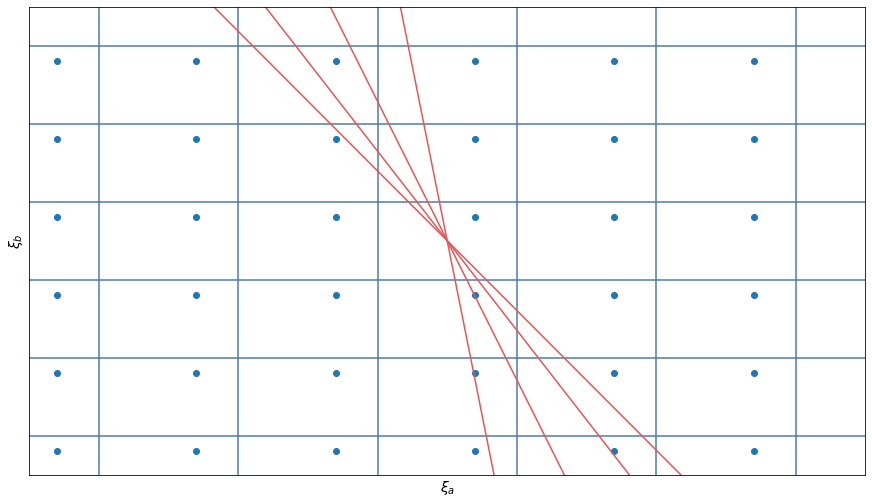

In [5]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

spectrum_size = [res_a / size_a, res_b / size_b]
n_replicas = 6

ax.set_xlabel(r'$\xi_a$', fontsize=14)
ax.set_ylabel(r'$\xi_b$', fontsize=14)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-n_replicas*spectrum_size[0]/2, n_replicas*spectrum_size[0]/2)
ax.set_ylim(-n_replicas*spectrum_size[1]/2, n_replicas*spectrum_size[1]/2)

ax.plot(np.repeat(compute_coordinates(n_replicas, spectrum_size[0]), 3), np.tile([-1000.0, 1000.0, np.nan], n_replicas), color='lfd:signal')
ax.plot(np.tile([-1000.0, 1000.0, np.nan], n_replicas), np.repeat(compute_coordinates(n_replicas, spectrum_size[1]), 3), color='lfd:signal')
ax.scatter(np.repeat(compute_coordinates(n_replicas, spectrum_size[0]), n_replicas) - spectrum_size[0]*0.3,
           np.tile(compute_coordinates(n_replicas, spectrum_size[1]), n_replicas) - spectrum_size[1]*0.2)

ax.plot(*frequency_eye_to_display(np.array([-1000.0, 1000.0]), 0.0, z_r, z_a, z_b, z_f[0]), color='lfd:retina')
ax.plot(*frequency_eye_to_display(np.array([-1000.0, 1000.0]), 0.0, z_r, z_a, z_b, z_f[1]), color='lfd:retina')
ax.plot(*frequency_eye_to_display(np.array([-1000.0, 1000.0]), 0.0, z_r, z_a, z_b, z_f[2]), color='lfd:retina')
ax.plot(*frequency_eye_to_display(np.array([-1000.0, 1000.0]), 0.0, z_r, z_a, z_b, z_f[3]), color='lfd:retina')
pass

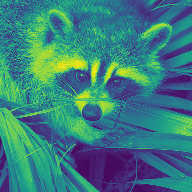

(192, 192) uint8 | total size: 3.4332275390625e-05 GiB


In [6]:
scene_image = misc.face(True).T[-769:-1:4, ::-4]
display_image(scene_image)
array_info(scene_image)

Oversampling the light field signal...


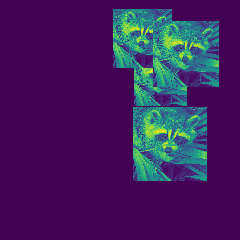

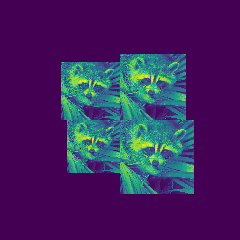

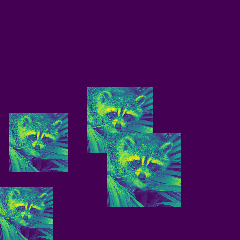

(240, 240, 240, 240) uint8 | total size: 3.08990478515625 GiB
Wall time: 1min 56s


In [7]:
%%time
print('Oversampling the light field signal...')

signal_AABB = sample_2d_scene(scene_image, res_r, res_A, res_B, size_r, size_a, size_b, z_r, z_a, z_b, z_f[0], 0, 0)

signal_AABB_temp = sample_2d_scene(scene_image, res_r, res_A, res_B, size_r, size_a, size_b, z_r, z_a, z_b, z_f[1], 0, res_r//2)
nonzero_idx = np.nonzero(signal_AABB_temp)
signal_AABB[nonzero_idx] = signal_AABB_temp[nonzero_idx]

signal_AABB_temp = sample_2d_scene(scene_image, res_r, res_A, res_B, size_r, size_a, size_b, z_r, z_a, z_b, z_f[2], res_r//2, res_r//2)
nonzero_idx = np.nonzero(signal_AABB_temp)
signal_AABB[nonzero_idx] = signal_AABB_temp[nonzero_idx]

signal_AABB_temp = sample_2d_scene(scene_image, res_r, res_A, res_B, size_r, size_a, size_b, z_r, z_a, z_b, z_f[3], res_r//2, 0)
nonzero_idx = np.nonzero(signal_AABB_temp)
signal_AABB[nonzero_idx] = signal_AABB_temp[nonzero_idx]

del nonzero_idx
del signal_AABB_temp

display_image(signal_AABB[0, 0, ::-1, ::-1])
display_image(signal_AABB[res_A//2, res_A//2, ::-1, ::-1])
display_image(signal_AABB[-1, -1, ::-1, ::-1])

array_info(signal_AABB)

Downsampling the unfiltered supersampled light field signal...


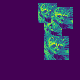

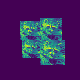

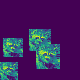

(80, 80, 80, 80) uint8 | total size: 0.03814697265625 GiB
Wall time: 71.8 ms


In [8]:
%%time
print('Downsampling the unfiltered supersampled light field signal...')

signal_aabb = decimate_lf(signal_AABB, oversampling).copy()

display_image(signal_aabb[0, 0, ::-1, ::-1])
display_image(signal_aabb[res_a//2, res_a//2, ::-1, ::-1])
display_image(signal_aabb[-1, -1, ::-1, ::-1])

array_info(signal_aabb)

Prefiltering the downsampled light field signal with unsinc...
Spectrum before filtering:


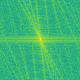

Spectrum after filtering:


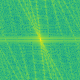

Light field after filtering:


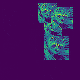

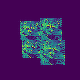

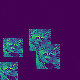

(80, 80, 80, 80) float32 | total size: 0.152587890625 GiB
Wall time: 2.08 s


In [9]:
%%time
print('Prefiltering the downsampled light field signal with unsinc...')

spectrum_aabb = np.empty((res_a, res_a, res_b, res_b//2+1), dtype=np.complex64)
rfft4(signal_aabb, spectrum_aabb, n_blocks=5)

print('Spectrum before filtering:')
display_image(scipy_fft.fftshift(np.log(1.0 + np.abs(spectrum_aabb[:, 0, :, 0]))))

unsinc_aabb = sinc_4d(res_a, res_b, 1, 1)
np.reciprocal(unsinc_aabb, out=unsinc_aabb)
np.multiply(spectrum_aabb, unsinc_aabb, out=spectrum_aabb)
del unsinc_aabb

print('Spectrum after filtering:')
display_image(scipy_fft.fftshift(np.log(1.0 + np.abs(spectrum_aabb[:, 0, :, 0]))))

unsinc_aabb_signal_aabb = np.empty((res_a, res_a, res_b, res_b), dtype=np.float32)
irfft4(spectrum_aabb, unsinc_aabb_signal_aabb, n_blocks=5)
del spectrum_aabb

print('Light field after filtering:')
display_image(unsinc_aabb_signal_aabb[0, 0, ::-1, ::-1])
display_image(unsinc_aabb_signal_aabb[res_a//2, res_a//2, ::-1, ::-1])
display_image(unsinc_aabb_signal_aabb[-1, -1, ::-1, ::-1])

array_info(unsinc_aabb_signal_aabb)

Prefiltering the oversampled light field signal with clipped unsinc and then downsampling it...
Spectrum before filtering:


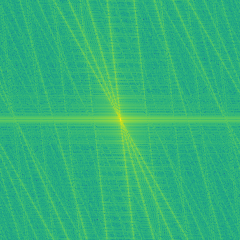

Spectrum after filtering:


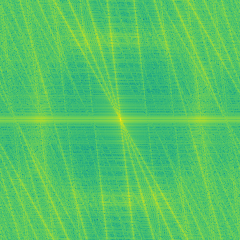

Light field after filtering:


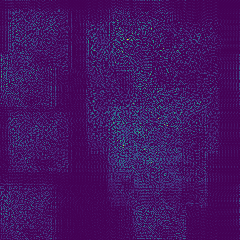

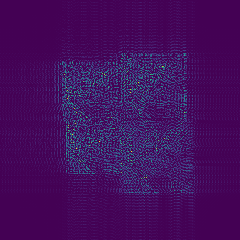

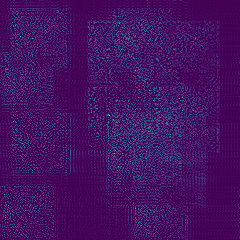

Light field after downsampling:


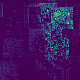

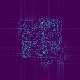

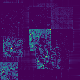

(80, 80, 80, 80) float32 | total size: 0.152587890625 GiB
Wall time: 1min 47s


In [10]:
%%time
print('Prefiltering the oversampled light field signal with clipped unsinc and then downsampling it...')

spectrum_AABB = np.empty((res_A, res_A, res_B, res_B//2+1), dtype=np.complex64)
rfft4(signal_AABB, spectrum_AABB, n_blocks=15)

print('Spectrum before filtering:')
display_image(scipy_fft.fftshift(np.log(1.0 + np.abs(spectrum_AABB[:, 0, :, 0]))))

unsinc_AABB = sinc_4d(res_A, res_B, oversampling, oversampling)
np.reciprocal(unsinc_AABB, out=unsinc_AABB)
np.clip(unsinc_AABB, -20.0, 20.0, out=unsinc_AABB)
np.multiply(spectrum_AABB, unsinc_AABB, out=spectrum_AABB)
del unsinc_AABB

print('Spectrum after filtering:')
display_image(scipy_fft.fftshift(np.log(1.0 + np.abs(spectrum_AABB[:, 0, :, 0]))))

unsinc_AABB_signal_AABB = np.empty((res_A, res_A, res_B, res_B), dtype=np.float32)
irfft4(spectrum_AABB, unsinc_AABB_signal_AABB, n_blocks=15)
del spectrum_AABB

print('Light field after filtering:')
display_image(unsinc_AABB_signal_AABB[0, 0, ::-1, ::-1])
display_image(unsinc_AABB_signal_AABB[res_A//2, res_A//2, ::-1, ::-1])
display_image(unsinc_AABB_signal_AABB[-1, -1, ::-1, ::-1])

unsinc_AABB_signal_aabb = decimate_lf(unsinc_AABB_signal_AABB, oversampling).copy()
del unsinc_AABB_signal_AABB

print('Light field after downsampling:')
display_image(unsinc_AABB_signal_aabb[0, 0, ::-1, ::-1])
display_image(unsinc_AABB_signal_aabb[res_a//2, res_a//2, ::-1, ::-1])
display_image(unsinc_AABB_signal_aabb[-1, -1, ::-1, ::-1])

array_info(unsinc_AABB_signal_aabb)

Prefiltering the oversampled light field signal with antialiasing filter and then downsampling it...
Spectrum before antialiasing:


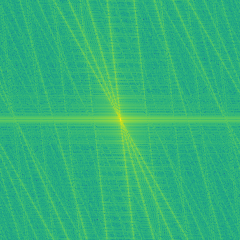

  0%|          | 0/40960000 [00:00<?, ?it/s]

Spectrum after antialiasing:


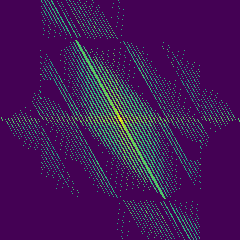

Light field after antialiasing:


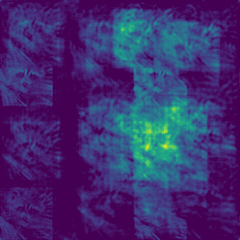

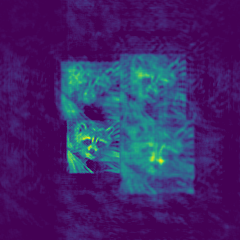

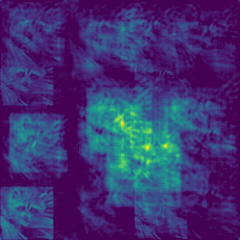

Light field after downsampling:


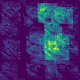

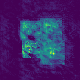

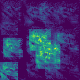

(80, 80, 80, 80) float32 | total size: 0.152587890625 GiB
Spectrum after antialiasing and unsinc:


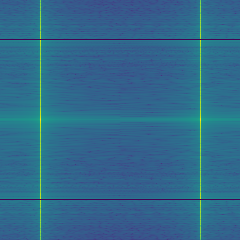

Light field after antialiasing and unsinc:


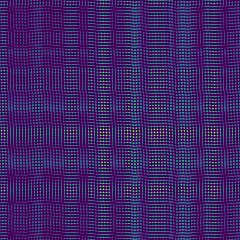

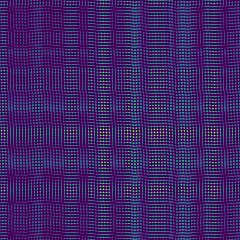

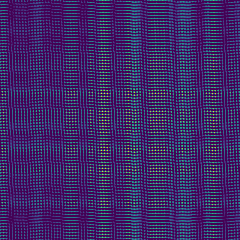

Light field after downsampling:


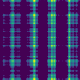

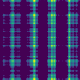

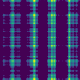

(80, 80, 80, 80) float32 | total size: 0.152587890625 GiB
Wall time: 1h 19min 44s


In [11]:
%%time
print('Prefiltering the oversampled light field signal with antialiasing filter and then downsampling it...')

spectrum_AABB = np.empty((res_A, res_A, res_B, res_B//2+1), dtype=np.complex64)
rfft4(signal_AABB, spectrum_AABB, n_blocks=15)

print('Spectrum before antialiasing:')
display_image(scipy_fft.fftshift(np.log(1.0 + np.abs(spectrum_AABB[:, 0, :, 0]))))

antialias_AABB = antialiasing_filter(res_A, res_B, res_a, res_b, size_a, size_b, z_r, z_a, z_b, z_f[0], pupil_diameter)
np.multiply(spectrum_AABB, antialias_AABB, out=spectrum_AABB)
del antialias_AABB

print('Spectrum after antialiasing:')
display_image(scipy_fft.fftshift(np.log(1.0 + np.abs(spectrum_AABB[:, 0, :, 0]))))

antialias_AABB_signal_AABB = np.empty((res_A, res_A, res_B, res_B), dtype=np.float32)
irfft4(spectrum_AABB, antialias_AABB_signal_AABB, n_blocks=15)

print('Light field after antialiasing:')
display_image(antialias_AABB_signal_AABB[0, 0, ::-1, ::-1])
display_image(antialias_AABB_signal_AABB[res_A//2, res_A//2, ::-1, ::-1])
display_image(antialias_AABB_signal_AABB[-1, -1, ::-1, ::-1])

antialiased_AABB_signal_aabb = decimate_lf(antialias_AABB_signal_AABB, oversampling).copy()
del antialias_AABB_signal_AABB

print('Light field after downsampling:')
display_image(antialiased_AABB_signal_aabb[0, 0, ::-1, ::-1])
display_image(antialiased_AABB_signal_aabb[res_a//2, res_a//2, ::-1, ::-1])
display_image(antialiased_AABB_signal_aabb[-1, -1, ::-1, ::-1])

array_info(antialiased_AABB_signal_aabb)

unsinc_AABB = sinc_4d(res_A, res_B, oversampling, oversampling)
np.reciprocal(unsinc_AABB, out=unsinc_AABB)
np.multiply(spectrum_AABB, unsinc_AABB, out=spectrum_AABB)
del unsinc_AABB

print('Spectrum after antialiasing and unsinc:')
display_image(scipy_fft.fftshift(np.log(1.0 + np.abs(spectrum_AABB[:, 0, :, 0]))))

unsinc_antialias_AABB_signal_AABB = np.empty((res_A, res_A, res_B, res_B), dtype=np.float32)
irfft4(spectrum_AABB, unsinc_antialias_AABB_signal_AABB, n_blocks=15)
del spectrum_AABB

print('Light field after antialiasing and unsinc:')
display_image(unsinc_antialias_AABB_signal_AABB[0, 0, ::-1, ::-1])
display_image(unsinc_antialias_AABB_signal_AABB[res_A//2, res_A//2, ::-1, ::-1])
display_image(unsinc_antialias_AABB_signal_AABB[-1, -1, ::-1, ::-1])

unsinc_antialias_AABB_signal_aabb = decimate_lf(unsinc_antialias_AABB_signal_AABB, oversampling).copy()
del unsinc_antialias_AABB_signal_AABB

print('Light field after downsampling:')
display_image(unsinc_antialias_AABB_signal_aabb[0, 0, ::-1, ::-1])
display_image(unsinc_antialias_AABB_signal_aabb[res_a//2, res_a//2, ::-1, ::-1])
display_image(unsinc_antialias_AABB_signal_aabb[-1, -1, ::-1, ::-1])

array_info(unsinc_antialias_AABB_signal_aabb)

In [12]:
#%%time
#print('Prefiltering the downsampled light field signal with unsinc 3.0...')

#visibility = lf_visibility(res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f[0], pupil_diameter)
#display_image(visibility)
#array_info(visibility)

#spectrum = np.log(1 + np.abs(scipy_fft.fft2(visibility)))
#display_image(scipy_fft.fftshift(spectrum))

Computing retinal images with focus at z_f[0]...


  0%|          | 0/147456 [00:00<?, ?it/s]

no filter:


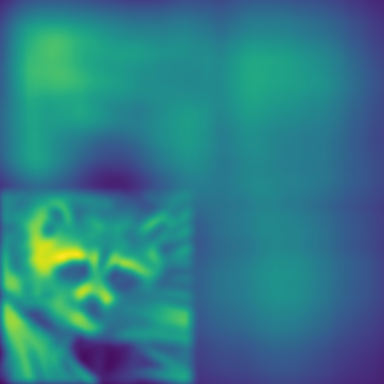

unsinc lowres:


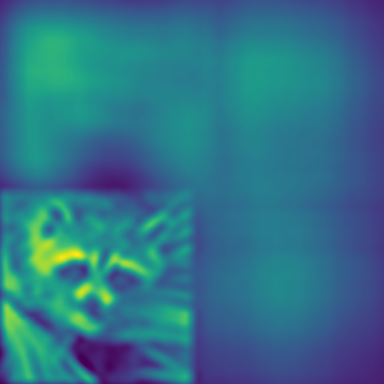

unsinc lowres nonneg:


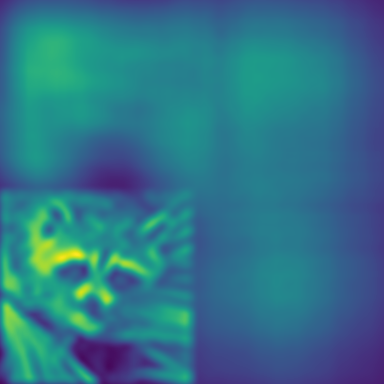

unsinc highres:


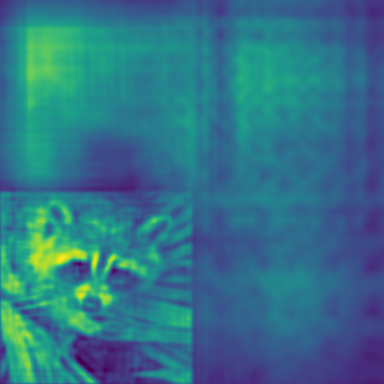

unsinc highres nonneg:


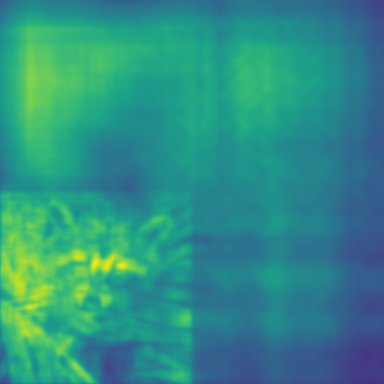

antialiased:


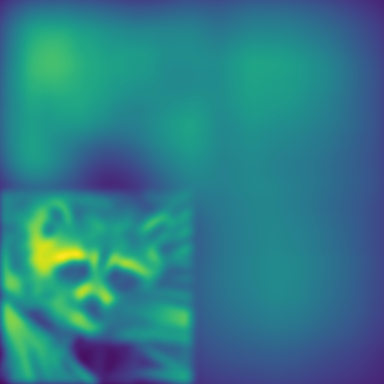

antialiased nonneg:


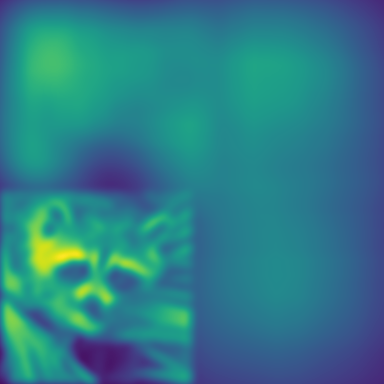

unsinc antialiased:


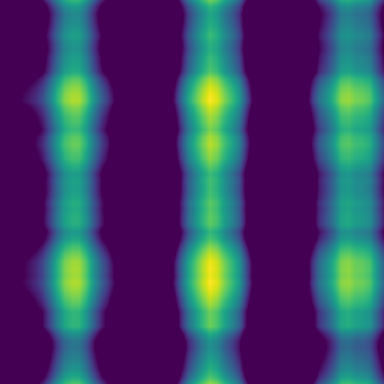

unsinc antialiased nonneg:


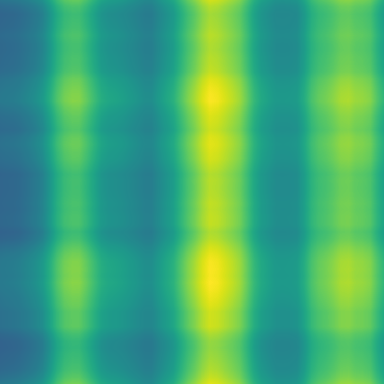

Wall time: 1h 22min 5s


In [13]:
%%time
print('Computing retinal images with focus at z_f[0]...')

signals_aabb = [signal_aabb,
                unsinc_aabb_signal_aabb, np.maximum(unsinc_aabb_signal_aabb, 0.0),
                unsinc_AABB_signal_aabb, np.maximum(unsinc_AABB_signal_aabb, 0.0),
                antialiased_AABB_signal_aabb, np.maximum(antialiased_AABB_signal_aabb, 0.0),
                unsinc_antialias_AABB_signal_aabb, np.maximum(unsinc_antialias_AABB_signal_aabb, 0.0)]
labels = ['no filter',
          'unsinc lowres', 'unsinc lowres nonneg',
          'unsinc highres', 'unsinc highres nonneg',
          'antialiased', 'antialiased nonneg',
          'unsinc antialiased', 'unsinc antialiased nonneg']

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, pitch_a, pitch_b, z_r, z_a, z_b, z_f[0], pupil_diameter, square_aperture)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i])

In [14]:
%%time
print('Computing retinal images with focus at z_f[1]...')

signals_aabb = [signal_aabb,
                unsinc_aabb_signal_aabb, np.maximum(unsinc_aabb_signal_aabb, 0.0),
                unsinc_AABB_signal_aabb, np.maximum(unsinc_AABB_signal_aabb, 0.0),
                antialiased_AABB_signal_aabb, np.maximum(antialiased_AABB_signal_aabb, 0.0),
                unsinc_antialias_AABB_signal_aabb, np.maximum(unsinc_antialias_AABB_signal_aabb, 0.0)]
labels = ['no filter',
          'unsinc lowres', 'unsinc lowres nonneg',
          'unsinc highres', 'unsinc highres nonneg',
          'antialiased', 'antialiased nonneg',
          'unsinc antialiased', 'unsinc antialiased nonneg']

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, pitch_a, pitch_b, z_r, z_a, z_b, z_f[1], pupil_diameter, square_aperture)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i])

Computing retinal images with focus at z_f[1]...


  0%|          | 0/147456 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
%%time
print('Computing retinal images with focus at z_f[2]...')

signals_aabb = [signal_aabb,
                unsinc_aabb_signal_aabb, np.maximum(unsinc_aabb_signal_aabb, 0.0),
                unsinc_AABB_signal_aabb, np.maximum(unsinc_AABB_signal_aabb, 0.0),
                antialiased_AABB_signal_aabb, np.maximum(antialiased_AABB_signal_aabb, 0.0),
                unsinc_antialias_AABB_signal_aabb, np.maximum(unsinc_antialias_AABB_signal_aabb, 0.0)]
labels = ['no filter',
          'unsinc lowres', 'unsinc lowres nonneg',
          'unsinc highres', 'unsinc highres nonneg',
          'antialiased', 'antialiased nonneg',
          'unsinc antialiased', 'unsinc antialiased nonneg']

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, pitch_a, pitch_b, z_r, z_a, z_b, z_f[2], pupil_diameter, square_aperture)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i])

In [ ]:
%%time
print('Computing retinal images with focus at z_f[3]...')

signals_aabb = [signal_aabb,
                unsinc_aabb_signal_aabb, np.maximum(unsinc_aabb_signal_aabb, 0.0),
                unsinc_AABB_signal_aabb, np.maximum(unsinc_AABB_signal_aabb, 0.0),
                antialiased_AABB_signal_aabb, np.maximum(antialiased_AABB_signal_aabb, 0.0),
                unsinc_antialias_AABB_signal_aabb, np.maximum(unsinc_antialias_AABB_signal_aabb, 0.0)]
labels = ['no filter',
          'unsinc lowres', 'unsinc lowres nonneg',
          'unsinc highres', 'unsinc highres nonneg',
          'antialiased', 'antialiased nonneg',
          'unsinc antialiased', 'unsinc antialiased nonneg']

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, pitch_a, pitch_b, z_r, z_a, z_b, z_f[3], pupil_diameter, square_aperture)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i])